# Polynomial Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [2]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'



test_split = 0.1

In [3]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [4]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.8200,0.2500,0.0200,0.2200,0.1400,0.0500,0.0200,0.3600,4.3000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,6.3800,7.4700,0.7800
1,0.8200,0.2500,0.0200,0.2400,0.1600,0.0600,0.0200,0.3300,4.2600,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,6.3600,7.8700,0.7700
2,0.7100,0.2500,0.0300,0.2500,0.1800,0.0400,0.0200,0.3300,4.9400,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,5.1900,7.7800,0.8700
3,0.8600,0.2500,0.0300,0.2600,0.1800,0.0400,0.0200,0.4100,4.9300,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,5.0000,8.6000,0.8600
4,0.8700,0.2900,0.0300,0.2700,0.2000,0.0500,0.0200,0.3000,4.8100,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,5.2500,8.0000,0.9100


In [5]:
data.shape

(2431, 18)

In [6]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 17 features


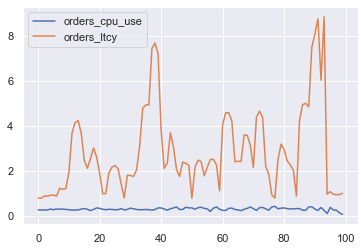

In [7]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][:100], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][:100], label='orders_ltcy')
plt.legend()
plt.show()


# Model

In [8]:
if True:
    from sklearn.preprocessing import PolynomialFeatures
    
    degree = 2

    # covert input data to polynomial form of some degree
    inputs_poly = PolynomialFeatures(degree=degree).fit_transform(inputs).astype(float)

    x_train, x_test, y_train, y_test = \
        train_test_split(inputs_poly, targets, test_size=test_split, shuffle=True, random_state=365)

    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


    reg = LinearRegression(normalize=False)

    
    model = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
    sfm = SelectFromModel(model)

    pipe = Pipeline(steps=[
        ('selector', sfm),
        ('scaler', StandardScaler()),         
        ('reg', reg)
    ])

    kfold = KFold(n_splits=10, shuffle=False)

    param_grid = {
        'selector__threshold': ['.1*mean', '.08*mean', '.05*mean', '.02*mean', '.001*mean']
        ,'reg__normalize': [False, True]
    }

    search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

    search.fit(x_train, y_train)

    y_hat_test = search.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))


R2 (testing) = -3.6881031618075873e+19


# Robust Linear Model

In [9]:
# RANSAC is an iterative algorithm for the robust estimation of parameters from a subset 
# of inliners from the complete data set.
# you can use this with all dataset including outliers
if False:    
    from sklearn.linear_model import RANSACRegressor

    ransac = RANSACRegressor(estimator)
    ransac.fit(x_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_hat_test = ransac.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))